# Assess & Clean Data

Load raw data, assess, clean and save in proper sets.


### Data Sources

- portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
- profile.json - demographic data for each customer
- transcript.json - records for transactions, offers received, offers viewed, and offers completed

### Changes

- 2018-12-19: Started project
- 2018-12-21: Finished basic cleaning
- 2019-01-07: Added block for transaction flagging
- 2019-01-08: Added block for aggregations


In [1]:
# load libraries

import numpy as np
import pandas as pd
from tqdm import tqdm

# my own custom functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# display settings
from IPython.display import display
pd.options.display.max_columns = None

from pathlib import Path  # to make file path references relative to notebook directory

In [2]:
# import data

portfolio_file = Path.cwd() / "data" / "raw" / "portfolio.json"
profile_file = Path.cwd() / "data" / "raw" / "profile.json"
transcript_file = Path.cwd() / "data" / "raw" / "transcript.json"

portfolio = pd.read_json(portfolio_file, orient='records', lines=True)
profile = pd.read_json(profile_file, orient='records', lines=True)
transcript = pd.read_json(transcript_file, orient='records', lines=True)

## Assess Data
### Check portfolio data

In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


Explanations: 
- id (string) - offer id
- offer_type (string) - type of offer ie BOGO (buy-one-get-one-free), discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - 
- channels (list of strings)

### Check profile data

In [5]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Explanations:

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

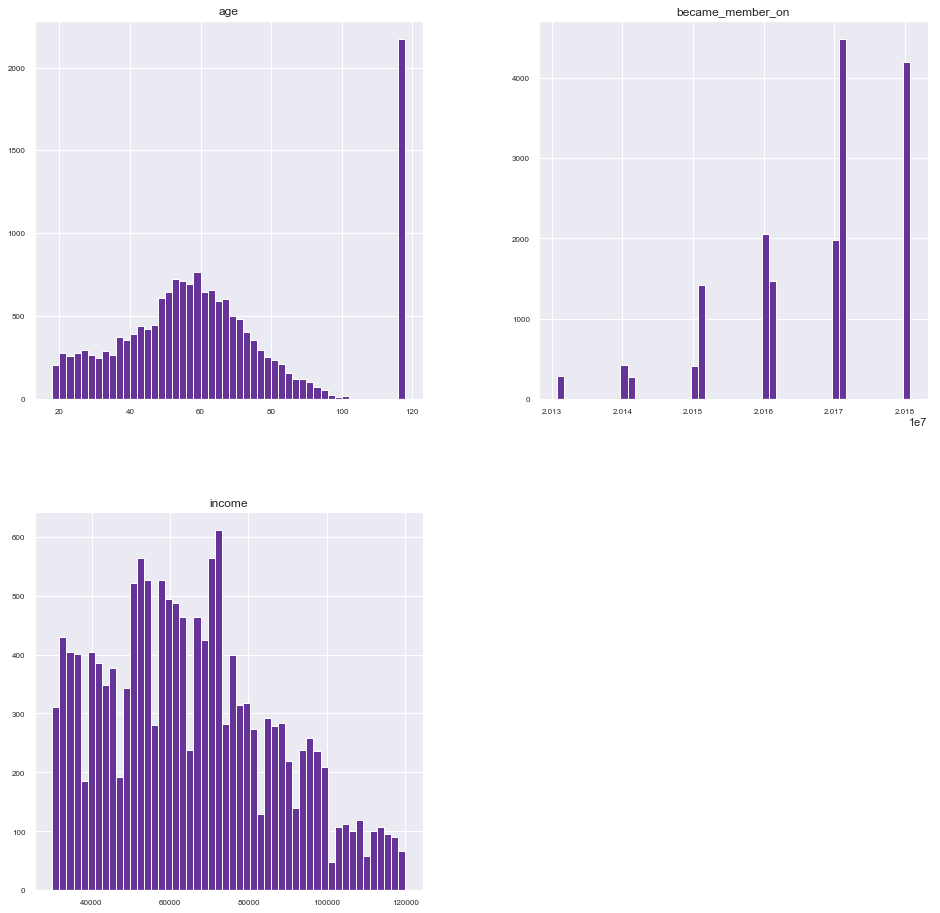

In [7]:
# plot numeric features
EDA.plot_num_hist(profile)

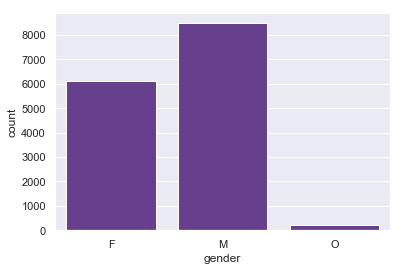

In [8]:
# plot categorical feature (gender)
sns.countplot(x='gender', data=profile, color=color);

In [9]:
# check missing values - seem to be the same profiles for all missing features

print("missing values 'income':", profile['income'].isnull().sum())
print("missing values 'gender':", profile['gender'].isnull().sum())
print("missing values 'age' (= age 118 years):", profile['age'].value_counts()[118])

missing values 'income': 2175
missing values 'gender': 2175
missing values 'age' (= age 118 years): 2175


### Check transcript data

In [10]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [11]:
transcript.sample(10)

,event,person,time,value
47966,transaction,506f28f5c45245b9baacf69e35e42cf6,132,{'amount': 0.58}
101721,transaction,f86cd307248848cda600b65e282836b9,282,{'amount': 1.73}
893,offer received,2fef3d75176e4b42b57a201a46950aba,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
158035,offer received,e648d51c487040748182aad1201ce7a3,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
140075,transaction,3b4d2c0594a04f13b7b0eca54cb3435a,372,{'amount': 5.24}
206329,offer received,dfd63a4ddd254fc8a6b840e371298d71,504,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
99296,offer viewed,967cb1c1c6094d2cb15f60b06137c1d1,270,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
226466,offer completed,782e48b0e782467eacad949132f74525,522,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
27881,offer viewed,ee8eccee44354ee38eea7b4704514136,42,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
4604,offer received,54bb578eff2946808f0ac8c33f641883,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


Explanations:
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours after start of 30 days test period. The data begins at time t=0
* value (dict of strings) - either an offer id or transaction amount depending on the record

## Clean Data

Cleaning tasks:
- portfolio: rename `id` col to `offer_id`
- portfolio: one-hot-encode `channels`
- portfolio: add `prop_reward` (`income` / `difficulty`)
- portfolio add `rel_difficulty` (`difficulty` / `duration` in days)
- portfolio: add `duration_hours` col 
- profile: rename `id` col to `person_id`
- profile: change `became_member_on` to `member_days` with duration integer (days, neg, starting from max date)
- profile: replace age = 118 with np.nan
- transcript: rename `person` to `person_id`
- transcript: create two separate columns for offer ids and amounts in `values`
- all files: simplify ids
- profile / promotion: set new ids as index

Further preparation tasks:
- transcript: flag every transaction if within valid period of a viewed promotion
- profile: add infos about aggregated transactions (number of purchases, amount per day etc.)
    - (could later be added for every promo)

In [12]:
"""rename columns"""

portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
profile.rename(columns={'id' : 'person_id'}, inplace=True)
transcript.rename(columns={'person' : 'person_id'}, inplace=True)

In [13]:
# check results
for df in [portfolio, profile, transcript]:
    print(df.columns)

Index(['channels', 'difficulty', 'duration', 'offer_id', 'offer_type',
       'reward'],
      dtype='object')
Index(['age', 'became_member_on', 'gender', 'person_id', 'income'], dtype='object')
Index(['event', 'person_id', 'time', 'value'], dtype='object')


In [14]:
"""portfolio: one-hot encode channels, set dtypes"""

for index, row in portfolio.iterrows():
    channel_string = ''.join(str(e) for e in portfolio.loc[index, 'channels'])
    for channel in ['web', 'email', 'mobile', 'social']:
        if channel in channel_string:
            portfolio.loc[index, channel] = 1
        else:
            portfolio.loc[index, channel] = 0
            
for col in portfolio[['web', 'email', 'mobile', 'social', 'offer_type']]:
    portfolio[col] = portfolio[col].astype('category', inplace=True)
portfolio.drop('channels', axis=1, inplace=True)

In [15]:
# check results
portfolio

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0.0,1.0,1.0,1.0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1.0,1.0,1.0,1.0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1.0,1.0,1.0,0.0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1.0,1.0,1.0,0.0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1.0,1.0,0.0,0.0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1.0,1.0,1.0,1.0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1.0,1.0,1.0,1.0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0.0,1.0,1.0,1.0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1.0,1.0,1.0,1.0
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1.0,1.0,1.0,0.0


In [16]:
"""portfolio: add new features prop_rewards, rel_difficulty and duration_hours"""

portfolio['prop_rewards'] = portfolio['reward'] / portfolio['difficulty']
portfolio['rel_difficulty'] = portfolio['difficulty'] / portfolio['duration']
portfolio['duration_hours'] = portfolio['duration'] * 24

In [17]:
# check results
display(portfolio.head())
display(portfolio.info())

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social,prop_rewards,rel_difficulty,duration_hours
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0.0,1.0,1.0,1.0,1.00,1.428571,168
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1.0,1.0,1.0,1.0,1.00,2.000000,120
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1.0,1.0,1.0,0.0,NaN,0.000000,96
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1.0,1.0,1.0,0.0,1.00,0.714286,168
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1.0,1.0,0.0,0.0,0.25,2.000000,240


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
difficulty        10 non-null int64
duration          10 non-null int64
offer_id          10 non-null object
offer_type        10 non-null category
reward            10 non-null int64
web               10 non-null category
email             10 non-null category
mobile            10 non-null category
social            10 non-null category
prop_rewards      8 non-null float64
rel_difficulty    10 non-null float64
duration_hours    10 non-null int64
dtypes: category(5), float64(2), int64(4), object(1)
memory usage: 1.1+ KB


None

In [18]:
"""profile: change `became_member_on` to `member_days` with duration integer (days, neg, starting from max date)"""

profile['became_member_on'] = profile['became_member_on'].astype(str) \
    .astype('datetime64[ns]', format = "%Y%m%d")

max_date = profile['became_member_on'].max()
profile['member_days'] = profile['became_member_on'].apply(lambda x: (max_date - x).days * -1)
profile.drop('became_member_on', axis=1, inplace=True)
print("max_date: ", max_date)

max_date:  2018-07-26 00:00:00


In [19]:
""" profile: replace age 118 with np.nan"""
profile['age'].replace(118, np.NaN, inplace=True)

In [20]:
# check results
profile.head()

,age,gender,person_id,income,member_days
0,NaN,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,-529
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,-376
2,NaN,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,-14
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,-443
4,NaN,None,a03223e636434f42ac4c3df47e8bac43,NaN,-356


In [21]:
"""create two separate columns for offer ids and amounts in transcript `values`"""

# see here why list call: https://stackoverflow.com/questions/17322668/typeerror-dict-keys-object-does-not-support-indexing
transcript['key'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['amount'] = transcript['value'].apply(lambda x: list(x.values())[0])
transcript['offer_id'] = transcript['amount']

transcript['amount'] = np.where(transcript['key'] == 'offer id', np.NaN, transcript['amount'])
transcript['amount'] = np.where(transcript['key'] == 'offer_id', np.NaN, transcript['amount'])
transcript['offer_id'] = np.where(transcript['key'] == 'amount', np.NaN, transcript['offer_id'])

transcript['amount'].astype(np.float64)
transcript.drop(['value', 'key'], axis=1, inplace=True)

In [22]:
# check result
transcript.sample(6)

,event,person_id,time,amount,offer_id
145065,transaction,668a6a51df4b454b93c31c945bc5eb76,384,10.13,NaN
76610,offer viewed,edfb73e167d14e86ae9ad18dcc53cc39,186,NaN,5a8bc65990b245e5a138643cd4eb9837
206194,offer received,888c4bee1cb5473a975e73150c6b40e1,504,NaN,3f207df678b143eea3cee63160fa8bed
201152,transaction,bc8244e584fb4f06a55201e47b9c4664,498,7.52,NaN
188022,offer viewed,fb8cc2d3feaa45b3a884c0a7a65cada0,456,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
53416,offer received,ca900921cfdd4b11a432df6f46a3e26d,168,NaN,fafdcd668e3743c1bb461111dcafc2a4


In [23]:
"""simplify ids"""

def map_id(df, column, prefix=None):
    """Map IDs in a DataFrame column to encoded ones, return list of encoded IDs
    and a mapping dict that can be used to encode other dataframes."""
    
    id_dict = dict()
    count = 1
    encoded_ids = []
    
    for old_val in df[column]:
        if old_val not in id_dict:
            id_dict[old_val] = str(prefix) + str(count)
            count+=1
        
        encoded_ids.append(id_dict[old_val])
    
    return encoded_ids, id_dict

In [24]:
# encode person ids in profile
encoded_person_ids, person_id_dict = map_id(profile, 'person_id', prefix="p_")
profile['person_id'] = encoded_person_ids

#check results
profile.head()

,age,gender,person_id,income,member_days
0,NaN,None,p_1,NaN,-529
1,55.0,F,p_2,112000.0,-376
2,NaN,None,p_3,NaN,-14
3,75.0,F,p_4,100000.0,-443
4,NaN,None,p_5,NaN,-356


In [25]:
# encode person ids in transcript
transcript['person_id'] = transcript['person_id'].apply(lambda x: person_id_dict[x])

# check results
transcript.sample()

,event,person_id,time,amount,offer_id
223072,offer completed,p_6311,516,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [26]:
# additional safety check
assert transcript.loc[271980, 'person_id'] == person_id_dict['98b81a8ffdd14bb986d80673491171a7']
print(transcript.loc[271980, :])

event        transaction
person_id         p_1252
time                 600
amount                12
offer_id             NaN
Name: 271980, dtype: object


In [27]:
# encode offer ids
portfolio = portfolio.sort_values('offer_type')
encoded_offer_ids, offer_id_dict = map_id(portfolio, 'offer_id', prefix="o_")
portfolio['offer_id'] = encoded_offer_ids

# check results
portfolio

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social,prop_rewards,rel_difficulty,duration_hours
0,10,7,o_1,bogo,10,0.0,1.0,1.0,1.0,1.000000,1.428571,168
1,10,5,o_2,bogo,10,1.0,1.0,1.0,1.0,1.000000,2.000000,120
3,5,7,o_3,bogo,5,1.0,1.0,1.0,0.0,1.000000,0.714286,168
8,5,5,o_4,bogo,5,1.0,1.0,1.0,1.0,1.000000,1.000000,120
4,20,10,o_5,discount,5,1.0,1.0,0.0,0.0,0.250000,2.000000,240
5,7,7,o_6,discount,3,1.0,1.0,1.0,1.0,0.428571,1.000000,168
6,10,10,o_7,discount,2,1.0,1.0,1.0,1.0,0.200000,1.000000,240
9,10,7,o_8,discount,2,1.0,1.0,1.0,0.0,0.200000,1.428571,168
2,0,4,o_9,informational,0,1.0,1.0,1.0,0.0,NaN,0.000000,96
7,0,3,o_10,informational,0,0.0,1.0,1.0,1.0,NaN,0.000000,72


In [28]:
transcript.head()

,event,person_id,time,amount,offer_id
0,offer received,p_4,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,p_5,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,p_6,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,p_7,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,p_8,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [29]:
# encode offer ids in transcript - different treatment because of NaN values

new_ids = []
for row in transcript['offer_id']:
    if row in offer_id_dict.keys():
        id = offer_id_dict[row]
    else:
        id = np.NaN
        
    new_ids.append(id)
    
transcript['offer_id'] = new_ids

# check results
transcript.sample(5)

,event,person_id,time,amount,offer_id
30375,transaction,p_9238,48,6.83,NaN
281950,transaction,p_1200,624,9.38,NaN
128397,offer viewed,p_7132,342,NaN,o_6
143789,transaction,p_1888,384,2.09,NaN
11620,offer received,p_8927,0,NaN,o_3


In [30]:
# additional safety checks
assert transcript.loc[228390, 'offer_id'] == offer_id_dict['fafdcd668e3743c1bb461111dcafc2a4']
assert transcript.loc[142891, 'offer_id'] == offer_id_dict['4d5c57ea9a6940dd891ad53e9dbe8da0']
print(transcript.loc[142891, :])

event        offer viewed
person_id         p_11287
time                  378
amount                NaN
offer_id              o_2
Name: 142891, dtype: object


In [31]:
"""profile / promotion: set new ids as index"""

profile.set_index('person_id', inplace=True)
portfolio.set_index('offer_id', inplace=True)

In [32]:
# check results
display(profile.head())
display(portfolio)

,age,gender,income,member_days
person_id,,,,
p_1,NaN,None,NaN,-529
p_2,55.0,F,112000.0,-376
p_3,NaN,None,NaN,-14
p_4,75.0,F,100000.0,-443
p_5,NaN,None,NaN,-356


,difficulty,duration,offer_type,reward,web,email,mobile,social,prop_rewards,rel_difficulty,duration_hours
offer_id,,,,,,,,,,,
o_1,10,7,bogo,10,0.0,1.0,1.0,1.0,1.000000,1.428571,168
o_2,10,5,bogo,10,1.0,1.0,1.0,1.0,1.000000,2.000000,120
o_3,5,7,bogo,5,1.0,1.0,1.0,0.0,1.000000,0.714286,168
o_4,5,5,bogo,5,1.0,1.0,1.0,1.0,1.000000,1.000000,120
o_5,20,10,discount,5,1.0,1.0,0.0,0.0,0.250000,2.000000,240
o_6,7,7,discount,3,1.0,1.0,1.0,1.0,0.428571,1.000000,168
o_7,10,10,discount,2,1.0,1.0,1.0,1.0,0.200000,1.000000,240
o_8,10,7,discount,2,1.0,1.0,1.0,0.0,0.200000,1.428571,168
o_9,0,4,informational,0,1.0,1.0,1.0,0.0,NaN,0.000000,96


## Flag transactions
Flag every transaction with a promotion affiliation (or several) if it falls into an active promotion time span.

In [33]:
"""define function for timespan flagging"""

# extend transcript with an empty column (all Nan) for each promotion
columns_list = list(transcript.columns) + list(portfolio.index)
transcript = transcript.reindex(columns=columns_list)

# create a look-up dict containing the duration for the different offers
duration_dict = dict(zip(portfolio.index, portfolio['duration_hours']))

def flag_for_timespan(df, columns_list=columns_list, duration_dict=duration_dict):
    """Create dummy columns for all promotions and set flag of value 0 if an event 
    belongs to a promotion or a transaction falls into the duration timespan.
    
    INPUT:
        - df: dataframe, containing the pre-cleaned transactions
        - columns_list: list, containing the columns for the extended df
        - duration_dict: dict, containing offer ids as key, durations as values
      
    RETURNS:
        - df_extended: dataframe with flagged dummy columns added
    """
    
    # initialize empty df with dummy columns
    df_extended = pd.DataFrame(columns=columns_list)

    for person in tqdm(df['person_id'].unique()):
        df_slice = df.loc[df['person_id'] == person]
    
        for index, row in df_slice.iterrows():
            if df_slice.loc[index, 'event'] == 'offer received':
                o_id = df_slice.loc[index, 'offer_id']
                o_start = df_slice.loc[index, 'time']
                o_duration = duration_dict[o_id]
                o_end = o_start + o_duration - 1
#                 print(person, o_id, o_start, o_duration, o_end)

                df_slice[o_id] = np.where((df_slice['time'] >= o_start) & (df_slice['time'] <= o_end) \
                                         & ((df_slice['amount'] >= 0) | (df_slice['offer_id'] == o_id)), \
                                                     0, df_slice[o_id])
#         display(df_slice)
        df_extended = pd.concat([df_extended, df_slice], join='outer')
    
    return df_extended

In [34]:
# call function - ATTENTION: runtime approx 1 hour
## transcript_extended = flag_for_timespan(transcript)

In [35]:
# save hardcopy

transcript_extended_hardcopy = Path.cwd() / "data" / "interim" / "profile_extended.csv"
## transcript_extended.to_csv(transcript_extended_hardcopy, index=False)

# load hardcopy
transcript_extended = pd.read_csv(transcript_extended_hardcopy, )

In [36]:
# check results
transcript_extended.head(15)

,event,person_id,time,amount,offer_id,o_1,o_2,o_3,o_4,o_5,o_6,o_7,o_8,o_9,o_10
0,offer received,p_4,0,NaN,o_3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,offer viewed,p_4,6,NaN,o_3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,transaction,p_4,132,19.89,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,p_4,132,NaN,o_3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,transaction,p_4,144,17.78,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,offer received,p_4,168,NaN,o_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,offer viewed,p_4,216,NaN,o_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,transaction,p_4,222,19.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,transaction,p_4,240,29.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,transaction,p_4,378,23.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
"""define function for activation flagging"""

def flag_for_activation(df_extended):
    """Highlight / flag all transactions that are potentially activating customers. 
    This are the transactions between viewing and completion or if no completion
    between viewing and end of duration.
    
    INPUT:
        - df_extended: dataframe, output from previous flagging function
      
    RETURNS:
        - df_extended: dataframe with updated flags
    """
    
    for col in df_extended.columns[-10:]:
        index_start_list = []   
        
        for index, row in tqdm(df_extended.iterrows()):
            if df_extended.loc[index, 'event'] == 'offer viewed' and df_extended.loc[index, col] == 0:
                index_start = index
                index_start_list.append(index_start)

                for index_start in index_start_list:    
                    for idx, roww in df_extended.loc[index_start: , :].iterrows():
                        if df_extended.loc[idx, 'event'] == 'offer received' and df_extended.loc[idx, col] == 0:
                            index_stop = idx-1
                            break
                        elif df_extended.loc[idx, 'event'] == 'offer completed' and df_extended.loc[idx, col] == 0:
                            index_stop = idx
                            break

                    if index_stop < index_start:
                        index_stop = len(df_extended) -1

#                 print(index, index_start, index_stop)

                for i, rowww in df_extended.loc[index_start: index_stop].iterrows():
                    if df_extended.loc[i, col] == 0:
                        df_extended.loc[i, col] = 1
    
    return df_extended

In [38]:
# call function - ATTENTION: runtime approx 30 hours ...

## transcript_flagged = flag_for_activation(transcript_extended)

In [39]:
transcript_flagged.head(15)

NameError: name 'transcript_flagged' is not defined

## Add Aggregations

### Portfolio

In [47]:
"""add aggregated promo data"""  # note: views and completion are only counted if within duration of actual offer

promo_grouped = transcript_extended.groupby(['event', 'offer_id']).count()
promo_grouped.drop(['person_id', 'amount', 'time'], axis=1, inplace=True)
promo_grouped = promo_grouped.groupby('event').agg(np.sum).T
promo_grouped = promo_grouped.reindex(columns = list(['offer received', 'offer viewed', 'offer completed']))
promo_grouped = cleaning.edit_column_names(promo_grouped)  # cleans whitespace
promo_grouped['view_to_complete'] = promo_grouped['offer_completed'] / promo_grouped['offer_viewed']

# check new dataframe
display(promo_grouped)

,offer_received,offer_viewed,offer_completed,view_to_complete
o_1,7658,6675,3649,0.546667
o_2,7593,7218,3272,0.453311
o_3,7677,4122,4302,1.043668
o_4,7571,7191,4208,0.585176
o_5,7668,2651,3390,1.278763
o_6,7646,7329,5108,0.696957
o_7,7597,7326,5296,0.722905
o_8,7632,4056,3963,0.977071
o_9,7617,3752,0,0.000000
o_10,7618,6030,0,0.000000


In [48]:
# add to portfolio
portfolio_extended = pd.concat([portfolio, promo_grouped], axis=1)

# safety-check
assert len(portfolio_extended.columns) == len(portfolio.columns) + len(promo_grouped.columns)

# check results
portfolio_extended

,difficulty,duration,offer_type,reward,web,email,mobile,social,prop_rewards,rel_difficulty,duration_hours,offer_received,offer_viewed,offer_completed,view_to_complete
offer_id,,,,,,,,,,,,,,,
o_1,10,7,bogo,10,0.0,1.0,1.0,1.0,1.000000,1.428571,168,7658,6675,3649,0.546667
o_2,10,5,bogo,10,1.0,1.0,1.0,1.0,1.000000,2.000000,120,7593,7218,3272,0.453311
o_3,5,7,bogo,5,1.0,1.0,1.0,0.0,1.000000,0.714286,168,7677,4122,4302,1.043668
o_4,5,5,bogo,5,1.0,1.0,1.0,1.0,1.000000,1.000000,120,7571,7191,4208,0.585176
o_5,20,10,discount,5,1.0,1.0,0.0,0.0,0.250000,2.000000,240,7668,2651,3390,1.278763
o_6,7,7,discount,3,1.0,1.0,1.0,1.0,0.428571,1.000000,168,7646,7329,5108,0.696957
o_7,10,10,discount,2,1.0,1.0,1.0,1.0,0.200000,1.000000,240,7597,7326,5296,0.722905
o_8,10,7,discount,2,1.0,1.0,1.0,0.0,0.200000,1.428571,168,7632,4056,3963,0.977071
o_9,0,4,informational,0,1.0,1.0,1.0,0.0,NaN,0.000000,96,7617,3752,0,0.000000


### Profile

In [42]:
"""add aggregated data for promos, transactions"""  # note: views and completion only if within duration of actual offer

promo_grouped = pd.DataFrame(transcript_extended.groupby(['person_id', 'event']) ['time'].count())
promo_grouped = promo_grouped.unstack(level='event')
promo_grouped.columns = promo_grouped.columns.droplevel()
promo_grouped = promo_grouped.rename(columns={'transaction' : 'transactions'})
promo_grouped = promo_grouped.reindex(columns = list(['offer received', 'offer viewed', 'offer completed', 'transactions']))
promo_grouped = cleaning.edit_column_names(promo_grouped)  # cleans whitespace

# check new dataframe
display(promo_grouped.head())

,offer_received,offer_viewed,offer_completed,transactions
person_id,,,,
p_1,5.0,5.0,2.0,9.0
p_10,4.0,3.0,1.0,6.0
p_100,5.0,NaN,1.0,2.0
p_1000,4.0,4.0,NaN,5.0
p_10000,3.0,3.0,NaN,6.0


In [43]:
# aggregate total spendings
amount_grouped = pd.DataFrame(transcript_extended.groupby(['person_id'])['amount'].sum())
amount_grouped = amount_grouped.rename(columns={'amount' : 'total_amount'})

# check new dataframe
display(amount_grouped.head())

,total_amount
person_id,
p_1,20.40
p_10,15.62
p_100,34.04
p_1000,19.78
p_10000,7.28


In [44]:
# add to profile
profile_extended = pd.concat([profile, promo_grouped, amount_grouped], axis=1, sort=True)

# safety-check
assert len(profile_extended.columns) == len(profile.columns) + len(promo_grouped.columns) + len(amount_grouped.columns)

# check results
profile_extended.head()

,age,gender,income,member_days,offer_received,offer_viewed,offer_completed,transactions,total_amount
p_1,NaN,None,NaN,-529,5.0,5.0,2.0,9.0,20.40
p_10,NaN,None,NaN,-611,4.0,3.0,1.0,6.0,15.62
p_100,68.0,F,84000.0,-725,5.0,NaN,1.0,2.0,34.04
p_1000,67.0,M,44000.0,-225,4.0,4.0,NaN,5.0,19.78
p_10000,NaN,None,NaN,-446,3.0,3.0,NaN,6.0,7.28


## Save prepared files

In [49]:
# safe cleaned data

portfolio_clean = Path.cwd() / "data" / "processed" / "portfolio_clean.csv"
profile_clean = Path.cwd() / "data" / "processed" / "profile_clean.csv"
transcript_clean = Path.cwd() / "data" / "processed" / "transcript_clean.csv"

portfolio_extended.to_csv(portfolio_clean)
profile_extended.to_csv(profile_clean)
transcript_extended.to_csv(transcript_clean, index=False)

---